# RNN(LSTM)

In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
plt.style.use("ggplot")
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers
import tools.helper_functions as hf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed, Bidirectional, Activation
from keras.layers import Dense, SimpleRNN,Dropout,Flatten,LSTM
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading data set
df = pd.read_excel('data/eth_api_data.xlsx')
df.set_index('t', inplace=True)

In [3]:
price_data = df.filter(['price_usd_close'])

In [4]:
ts = price_data.values

In [5]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0,1)).fit(ts)
x_scaled = scaler.transform(ts)
x_scaled[0:5]

array([[8.01225380e-05],
       [6.81027123e-05],
       [6.35189561e-05],
       [1.56430138e-04],
       [1.86559650e-04]])

In [9]:
y = [x[0] for x in x_scaled]

In [10]:
split = int(len(x_scaled) * .9)
print(split)

2003


In [11]:
x_train = x_scaled[:split]
x_test = x_scaled[split:]
y_train = y[:split]
y_test = y[split:]

In [12]:
# Verifying that the data has the right dimensions
assert len(x_train) == len(y_train)
assert len(x_test) == len(y_test)


In [13]:
time_step = 3 # Time Step for the LSTM model
xtrain = []
ytrain = []
xtest = []
ytest = []

for i in range(time_step,len(x_train)):
  xtrain.append(x_train[i-time_step:i,:x_train.shape[1]])
  ytrain.append(y_train[i])
for i in range(time_step, len(y_test)):
  xtest.append(x_test[i-time_step:i,:x_test.shape[1]])
  ytest.append(y_test[i])

In [33]:
np.array(xtrain).shape

(2000, 3, 1)

In [15]:
xtrain, ytrain = np.array(xtrain), np.array(ytrain)
xtrain = np.reshape(xtrain,(xtrain.shape[0],xtrain.shape[1],xtrain.shape[2]))

xtest, ytest = np.array(xtest), np.array(ytest)
xtest = np.reshape(xtest,(xtest.shape[0],xtest.shape[1],xtest.shape[2]))

In [16]:
# Input shape is comprised of the time step and the number of obsevations
model = Sequential()
model.add(LSTM(4,input_shape=(xtrain.shape[1],xtrain.shape[2])))
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer='adam')
model.fit(
    xtrain,ytrain,epochs=100,validation_data=(xtest,ytest),batch_size=16,verbose=1
)

Epoch 1/100
125/125 [==============================] - 1s 5ms/step - loss: 0.0024 - val_loss: 0.1405
Epoch 2/100
125/125 [==============================] - 0s 2ms/step - loss: 8.1792e-04 - val_loss: 0.0278
Epoch 3/100
125/125 [==============================] - 0s 3ms/step - loss: 9.4907e-05 - val_loss: 0.0045
Epoch 4/100
125/125 [==============================] - 0s 3ms/step - loss: 4.8931e-05 - val_loss: 0.0034
Epoch 5/100
125/125 [==============================] - 0s 2ms/step - loss: 5.0185e-05 - val_loss: 0.0035
Epoch 6/100
125/125 [==============================] - 0s 3ms/step - loss: 4.9313e-05 - val_loss: 0.0040
Epoch 7/100
125/125 [==============================] - 0s 4ms/step - loss: 4.9311e-05 - val_loss: 0.0036
Epoch 8/100
125/125 [==============================] - 0s 4ms/step - loss: 5.0926e-05 - val_loss: 0.0029
Epoch 9/100
125/125 [==============================] - 0s 4ms/step - loss: 5.0461e-05 - val_loss: 0.0037
Epoch 10/100
125/125 [==============================] - 0s 

In [17]:
model.summary() # Summary of the model params

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 96        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Prediction phase
train_predict = model.predict(xtrain) 
test_predict = model.predict(xtest)

In [19]:
# Concatenating with an array of 0's since our scaler requires a 2D input
train_predict = np.c_[train_predict,np.zeros(train_predict.shape)]
test_predict = np.c_[test_predict,np.zeros(test_predict.shape)]

In [20]:
# Inverse transforming our data so the output is on the correct scale
train_predict = scaler.inverse_transform(train_predict)
train_predict = [x[0] for x in train_predict]

test_predict = scaler.inverse_transform(test_predict)
test_predict = [x[0] for x in test_predict]

In [21]:
print(train_predict[:5])
print(test_predict[:5])

[-2.220944015323844, -2.045228964562742, -1.869032076864569, -1.4489013539921607, -1.2391313119690004]
[1660.0038284113134, 1636.957847487466, 1678.1860540335983, 1715.774184580806, 1731.9550771702734]


In [22]:
train_score = mean_squared_error([x[0][0] for x in xtrain],train_predict, squared=False)
print('Train score: {}'.format(train_score))
test_score = mean_squared_error([x[0][0] for x in xtest],test_predict,squared=False)
print('Test score: {}'.format(test_score))

Train score: 348.7793453210711
Test score: 2439.2537060898585


In [25]:
# Generating the actual ETH prices
original_eth_price = [y[0] for y in ts[split:]]
original_eth_price[:5]

[1594.850253727536,
 1717.685278196146,
 1678.043157088794,
 1614.018496995099,
 1744.2960452079]

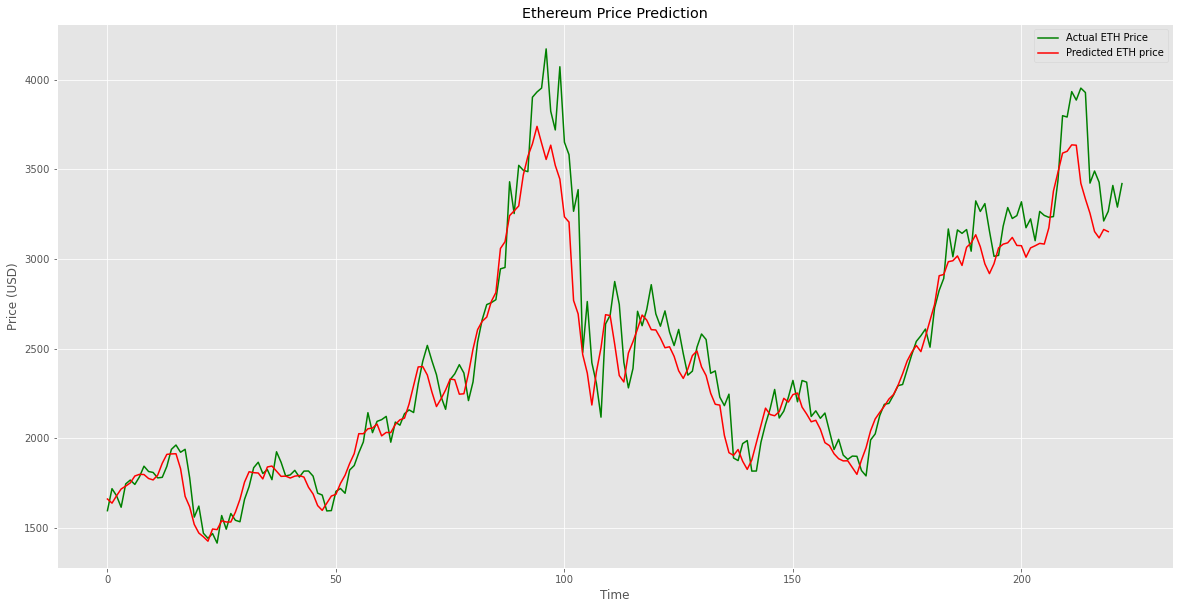

In [32]:
# Visualizing preds against the actual data in order to see how well it performed
plt.figure(figsize=(20,10))
plt.plot(original_eth_price,color='green',label='Actual ETH Price')
plt.plot(test_predict,color='red',label='Predicted ETH price')
plt.title('Ethereum Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show();